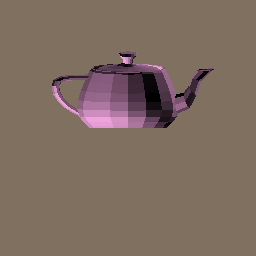

In [2]:
import json
import math
from PIL import Image


def find_len(p):
  return math.sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2])

def unitize(p):
  l = find_len(p)
  return [p[0]/l, p[1]/l, p[2]/l]

def cross(pA, pB):
  a1, a2, a3 = pA[0], pA[1], pA[2];
  b1, b2, b3 = pB[0], pB[1], pB[2];
  param1 = a2 * b3 - a3 * b2
  param2 = a3 * b1 - a1 * b3
  param3 = a1 * b2 - a2 * b1
  return [param1, param2, param3]

def createCamMatrix(camR, to):
  camU = [1, 0, 0]
  camV = [0, 1, 0]
  camN = [0, 0, 1]
  camMatrix = [[0] * 4 for i in range(4)]
  camMatrix[0] = [camU[0], camU[1], camU[2], -(camR[0]*camU[0]+camR[1]*camU[1]+camR[2]*camU[2])]
  camMatrix[1] = [camV[0], camV[1], camV[2], -(camR[0]*camV[0]+camR[1]*camV[1]+camR[2]*camV[2])]
  camMatrix[2] = [camN[0], camN[1], camN[2], -(camR[0]*camN[0]+camR[1]*camN[1]+camR[2]*camN[2])]
  camMatrix[3] = [0, 0, 0, 1]
  return camMatrix


def multiplyMatrixAndPoint(matrix, point):
  c0r0, c1r0, c2r0, c3r0 = matrix[0][0], matrix[0][1], matrix[0][2], matrix[0][3]
  c0r1, c1r1, c2r1, c3r1 = matrix[1][0], matrix[1][1], matrix[1][2], matrix[1][3]
  c0r2, c1r2, c2r2, c3r2 = matrix[2][0], matrix[2][1], matrix[2][2], matrix[2][3]
  c0r3, c1r3, c2r3, c3r3 = matrix[3][0], matrix[3][1], matrix[3][2], matrix[3][3]

  resultX = (point[0] * c0r0) + (point[1] * c1r0) + (point[2] * c2r0) + (point[3] * c3r0)
  resultY = (point[0] * c0r1) + (point[1] * c1r1) + (point[2] * c2r1) + (point[3] * c3r1)
  resultZ = (point[0] * c0r2) + (point[1] * c1r2) + (point[2] * c2r2) + (point[3] * c3r2)
  resultW = (point[0] * c0r3) + (point[1] * c1r3) + (point[2] * c2r3) + (point[3] * c3r3)

  return [resultX, resultY, resultZ, resultW]

def WSToNDC(camMatrix,NDCMat,vert):
  pt = [vert[0],vert[1],vert[2], 1]
  camPt = multiplyMatrixAndPoint(camMatrix,pt)
  proj_plane = 3
  doItForReal=1
  if doItForReal == 1:
    NDCPt = multiplyMatrixAndPoint(NDCMat,camPt)
    NDCx = NDCPt[0]/NDCPt[3]
    NDCy = NDCPt[1]/NDCPt[3]
    NDCz = NDCPt[2]/NDCPt[3]
  return [NDCx,NDCy]



with open('./Teapot3.json') as json_file:
    data = json.load(json_file)

fro = [0, 0, 20]
to = [0, 0, 0]


dist = 10.0
n, f, r, l, t, b = 40, 10, dist, -dist, -dist, dist
NDCMat = [[2*n/(r-l), 0, (r+l)/(r-l), 0], 
          [0, 2*n/(t-b), (t+b)/(t-b), 0], 
          [0, 0, -(f+n)/(f-n), -2*f*n/(f-n)], 
          [0, 0, -1, 0]]
NDCPt = [[], [], []]
w, h = 256, 256
img = Image.new('RGB',(w, h), (127,112,96))
z_buffer = [[math.inf] * 256 for i in range(256)]
data1 = data.get('data')
camMatrix = createCamMatrix(fro, to)


i = 0 
for dat in data1:
  i += 1
  x0 = dat['v0']['v'][0]
  x1 = dat['v1']['v'][0]
  x2 = dat['v2']['v'][0]
  y0 = dat['v0']['v'][1]
  y1 = dat['v1']['v'][1]
  y2 = dat['v2']['v'][1]
  z0 = dat['v0']['v'][2]
  z1 = dat['v1']['v'][2]
  z2 = dat['v2']['v'][2]

  vertex_all = [[x0, y0, z0], [x1, y1, z1], [x2, y2, z2]]
  NDCPt[0] = WSToNDC(camMatrix, NDCMat, vertex_all[0])
  NDCPt[1] = WSToNDC(camMatrix, NDCMat, vertex_all[1])
  NDCPt[2] = WSToNDC(camMatrix, NDCMat, vertex_all[2])

  scale = 255/2
  x0 = (NDCPt[0][0] + 1) * scale
  x1 = (NDCPt[1][0] + 1) * scale
  x2 = (NDCPt[2][0] + 1) * scale
  y0 = (NDCPt[0][1] + 1) * scale
  y1 = (NDCPt[1][1] + 1) * scale
  y2 = (NDCPt[2][1] + 1) * scale
  
  xmin = math.floor(min(x0, x1, x2))
  xmax = math.ceil(max(x0, x1, x2))
  ymin = math.floor(min(y0, y1, y2))
  ymax = math.ceil(max(y0, y1, y2))
  nx = dat['v0']['n'][0]
  ny = dat['v0']['n'][1]
  nz = dat['v0']['n'][2]
  dotp = float(0.707 * nx) + float(0.5 * ny) + float(0.5 * nz)

  if dotp < 0.0:
    dotp = -dotp
  elif dotp > 1.0:
    dotp = 1.0
  
  rgb = [float(0.95 * dotp), float(0.65 * dotp), float(0.88 * dotp)]
  col = (int(rgb[0] * 255) ,int(rgb[1] * 255), int(rgb[2] * 255))

  for y in range(ymin,ymax):
    for x in range(xmin, xmax):
      
      f01 = (y0-y1)*x + (x1-x0)*y + x0*y1 - x1*y0
      f12 = (y1-y2)*x + (x2-x1)*y + x1*y2 - x2*y1
      f20 = (y2-y0)*x + (x0-x2)*y + x2*y0 - x0*y2
      f01a = (y0-y1)*x2 + (x1-x0)*y2 + x0*y1 - x1*y0
      f12a = (y1-y2)*x0 + (x2-x1)*y0 + x1*y2 - x2*y1
      f20a = (y2-y0)*x1 + (x0-x2)*y1 + x2*y0 - x0*y2
      alpha = f12/f12a
      beta = f20/f20a
      gamma = f01/f01a
      z_at_pixel = alpha * z0 + beta * z1 + gamma * z2
      if(alpha >= 0 and beta >=0 and gamma >= 0):
        if(x >= 0 and y >= 0 and x < 256 and y < 256):
          if z_at_pixel < z_buffer[x][y]:
            img.putpixel((x,y),col)
            z_buffer[x][y] = z_at_pixel
display(img)
